In [1]:
from __future__ import (division, print_function)
import numpy as np

from dolfin import *
from alea.math_utils.param_pde.affine_field import AffineField
from alea.math_utils.tensor.tt_util import get_extendedtt_from_affine_field
from alea.application.tt_asgfem.affine_poisson_operator import AffinePoissonOperator
from alea.application.tt_asgfem.lognormal_poisson_operator import LognormalPoissonOperator
from alea.math_utils.param_pde.forward_operator.poisson import ParametricPoisson
from alea.math_utils.param_pde.mesh_util import (get_mesh, get_boundary)

from alea.math_utils.tensor.extended_fem_tt import (ExtendedFEMTT, ExtendedTT, BasisType)
from notebook_helper import (set_fem_fun, plot_fem_diff)
import matplotlib.pyplot as plt

%matplotlib inline

Create a coefficient field as an affine field representation 

$$
  a(x,y) = a_0(x) + \sum_{k=1}^\infty a_k(x)y_k
$$

where $a_0(x)$ is a FENICS expression argument, e.g. a constant, and $a_k(x)$ depends on the given type of 'coef' and 'amp'. 
In the following example we create a field as in [EGSZ].

In [3]:
field_options = {
    "coef_type": "cos", 
    "amptype": "decay-inf", 
    "decayexp": 2,
    "gamma": 0.9,
    "freqscale": 1.0,
    "freqskip": 0,
    "scale": 1.0,
    "coef_mean": 1.0
}

affine_field = AffineField(**field_options)

This object is a continuous function in $x\in D=[0,1]^2$ and $y=(y_1, y_2, \ldots) \in [-1, 1]^{\infty}$.

To create a realisation of this object, we need to define a function space. This is done by FENICS.

And a parameter realisation of a certain length $M$, which evaluates the field.

refined from 54 to 216 cells
refined from 216 to 864 cells
refined from 864 to 3456 cells


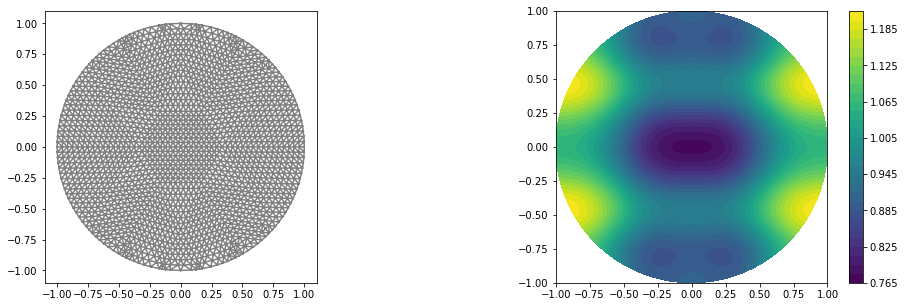

In [4]:
mesh = get_mesh("circle", mesh_nodes=1000)
family = 'CG'
degree = 2
fs = FunctionSpace(mesh, family, degree)

fig = plt.figure(figsize=(17, 5))
fig.add_subplot(121)
plot(mesh)

M = 10

y = np.random.rand(M)*2 - 1

af = affine_field(y, fs, project_result=True)

fig.add_subplot(122)
im = plot(af)
plt.colorbar(im)


The TT-ASGFEM formulation relays on the fact that the coefficient field can be represented as a Tensor Train. 
For the affine field, there exists an exact correspondence for a field representation with truncation level $M>0$ on a rank $M$ Tensor Train Manifold. 
Hence, we can create an extended Tensor Train with tensorized Legendre polynomials as basis. 

In [5]:
# create Extended-FEM-TT from affine field + function space + M
tt_affine_field = get_extendedtt_from_affine_field(affine_field, fs, M)
# sample a number in [-1, 1]^M
y = np.random.rand(M)*2 - 1

# evaluate affine field
af = affine_field(y, fs, project_result=True)

# evaluate TT and create fenics function object (optional)
tt_affine_field.normalise()
tt_af = tt_affine_field.sample(y, project_result=True)

plot_fem_diff(af, tt_af, fs, "True field", "TT approximation")


In [6]:
from alea.utils.tictoc import TicToc

with TicToc(key="evaluate affine field", active=True, do_print=False):
    _ = affine_field(y, fs)

with TicToc(key="evaluate TT field", active=True, do_print=False):
    _ = tt_affine_field.sample(y)

TicToc.sortedTimes()
TicToc.clear()


o==============================================o
|        Sorted tasks by amount of time        |
o==============================================o
| evaluate affine field    1.036656  seconds |
| evaluate TT field        0.003070  seconds |
o==============================================o


The same can be done for the log-normal coefficient field representation 
$$
  a(x,y) = \exp\left(a_0(x) + \sum_{k=1}^\infty a_k(x)y_k\right)
$$
with $y_k\sim \mathcal{N}(0, 1)$.


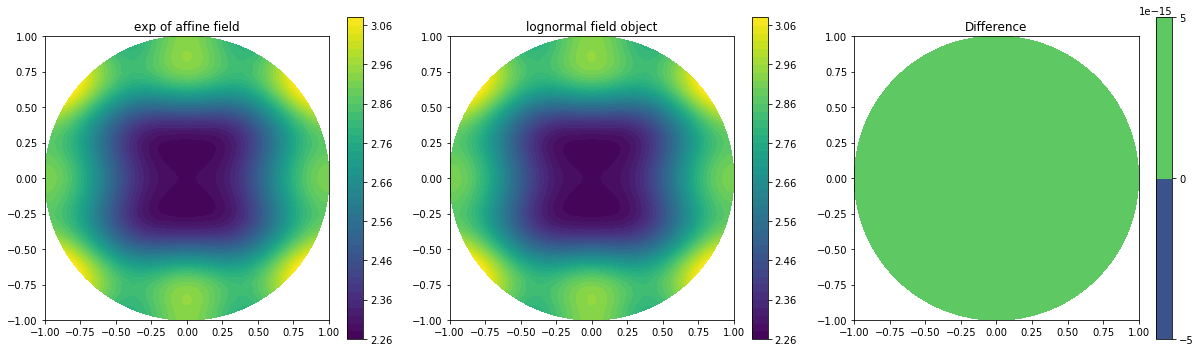

In [7]:
from alea.math_utils.param_pde.lognormal_field import LognormalField

exp_field_options = {
    "coef_type": "cos", 
    "amptype": "decay-inf", 
    "decayexp": 2,
    "gamma": 0.9,
    "freqscale": 1.0,
    "freqskip": 0,
    "scale": 1.0,
    "coef_mean": 1.0,
    "rv_type": "normal"
}

exp_field_af = AffineField(**exp_field_options)
exp_field = LognormalField(exp_field_af)

y = np.random.rand(M)*2 - 1

# evaluate affine field
af = affine_field(y, fs, project_result=True)
af.vector().set_local(np.exp(af.vector()[:]))

# evaluate TT and create fenics function object (optional)
exp_af = exp_field(y, fs, project_result=True)

plot_fem_diff(af, exp_af, fs, "exp of affine field", "lognormal field object")

Since the log-normal field has no explicit expression in a polynomial basis, we need to approximate it. 
Therefore we define a tensor set of (transformed-) Hermite polynomials and a Rank parameter.

### TODO: describe reduced basis format

Here, we use an isotrop tensor set of degree 7
and a rank of maximal 50.

In [8]:
from alea.math_utils.param_pde.lognormal_field import TTLognormalSemidiscreteField
exp_field_degs = [7]*M
exp_field_ranks = [1] + [50]*M + [1]
tt_exp_field = TTLognormalSemidiscreteField(exp_field_af, exp_field_degs, exp_field_ranks, fs)

o============================================================o
|               Sorted tasks by amount of time               |
o============================================================o
| 3. compute correlation matrix          24.522217  seconds |
| 3.4 numpy dot                          14.369027  seconds |
| 3.0 create EB                          8.684468  seconds |
| 3.6 compute reduced basis              3.227034  seconds |
| 3.2 multiply column with weights       1.467155  seconds |
| 1. Create mesh and FunctionSpace       0.370440  seconds |
| 3.5 compute SVD                        0.193650  seconds |
| 2. Get quadrature nodes and weights    0.074886  seconds |
| 3.1 reshape EB                         0.000490  seconds |
o============================================================o


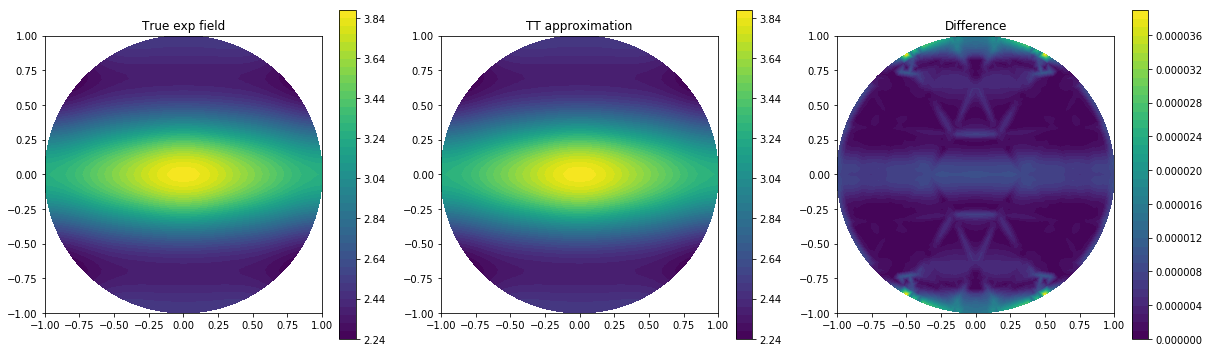

In [9]:
y = np.random.rand(M)*2 - 1

# evaluate affine field
truth = exp_field(y, fs, project_result=True)

# evaluate TT and create fenics function object (optional)
approx = tt_exp_field(y, fs, project_result=True)

plot_fem_diff(truth, approx, fs, "True exp field", "TT approximation")


Since the semi-discrete coefficient is not an extended tensor train but a slight modification on a quadrature mesh, we need to construct a tensor train out of it. 
This is handled by the *FullyDiscreteField*.


In [10]:
from alea.math_utils.param_pde.lognormal_field import TTLognormalFullyDiscreteField

disc_exp_field = TTLognormalFullyDiscreteField(tt_exp_field)


o============================================================o
|               Sorted tasks by amount of time               |
o============================================================o
| 3. Create Cores                        27.955916  seconds |
| 3. compute correlation matrix          20.195555  seconds |
| 3.4 numpy dot                          11.577998  seconds |
| 3.0 create EB                          7.305594  seconds |
| 3.6 compute reduced basis              2.545977  seconds |
| 3.2 multiply column with weights       1.311068  seconds |
| 1. Create mesh and FunctionSpace       0.627731  seconds |
|   EB                                   0.491967  seconds |
| 3.5 compute SVD                        0.164738  seconds |
| 2. Get quadrature nodes and weights    0.139668  seconds |
|   left                                 0.115489  seconds |
|   bfun retval                          0.069463  seconds |
|   final b0                             0.005503  seconds |
|   herms      

In [11]:
y = np.random.rand(M)*2 - 1

# evaluate affine field
truth = tt_exp_field(y, fs, project_result=True)

# evaluate TT and create fenics function object (optional)
approx = disc_exp_field(y, fs, project_result=True)

plot_fem_diff(truth, approx, fs, "Semi discrete TT field", "Fully discrete TT field")

Now we can define the Forward operator, which handles the creation of the bilinear- and linearform, as well as the solution process.

In [12]:
problem = "lognormal"

def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(fs, Constant(0.0), boundary)
rhs = Constant(1.0)

if problem == "affine":
    coef = affine_field
    pw_problem = ParametricPoisson(coef, rhs, fs, bc)

    degs = [10]*M
    tt_problem = AffinePoissonOperator(coef, rhs, fs, bc, degs) 
elif problem == "lognormal":
    pw_problem = ParametricPoisson(exp_field, rhs, fs, bc)
    degs = [5]*M
    tt_problem = LognormalPoissonOperator(exp_field_af, exp_field_degs, exp_field_ranks, rhs, fs, bc, degs)
    

o============================================================o
|               Sorted tasks by amount of time               |
o============================================================o
| 3. Create Cores                        22.910825  seconds |
| 3. compute correlation matrix          20.690902  seconds |
| 3.4 numpy dot                          12.500882  seconds |
| 3.0 create EB                          6.835824  seconds |
| 3.6 compute reduced basis              2.792837  seconds |
| 3.2 multiply column with weights       1.353188  seconds |
|   EB                                   0.377504  seconds |
| create EB                              0.317645  seconds |
| 1. Create mesh and FunctionSpace       0.305969  seconds |
| retval                                 0.240119  seconds |
| 3.5 compute SVD                        0.172213  seconds |
|   left                                 0.102120  seconds |
| 2. Get quadrature nodes and weights    0.094149  seconds |
| own tensordot

o============================================================o
|               Sorted tasks by amount of time               |
o============================================================o
| 3. Create Cores                        23.657653  seconds |
| 3. compute correlation matrix          19.108470  seconds |
| 3.4 numpy dot                          11.589723  seconds |
| 3.0 create EB                          6.203062  seconds |
| 3.6 compute reduced basis              2.547677  seconds |
| 3.2 multiply column with weights       1.314735  seconds |
| 1. Create mesh and FunctionSpace       0.300629  seconds |
| 3.5 compute SVD                        0.163048  seconds |
| 2. Get quadrature nodes and weights    0.067265  seconds |
| 3.1 reshape EB                         0.000276  seconds |
o============================================================o


AttributeError: 'dolfin.cpp.parameter.GlobalParameters' object has no attribute 'linear_algebra_backend'

The call of the solver is a bit tricky a.t.m. 
There are a lot of parameters and different kind of solvers implemented.

Moreover, one can define an initial value which would be used by the alternating schemes. 

For a full list of possible local-solver, alternating schemes and preconditioner, please look in the code...

In [14]:
ranks = [1] + [5]*M + [1]

iterations = 1000
als_tol = 1e-8
initial_value = []
load = False # flag to load a solution if found

solver = "TTSparseALS"
solver_options = None

# solver = "XerusALS"
# solver_method = "ALS" # "GMRES" # "ASD"
# solver_options = {"method": solver_method, "symmetric": True}

preconditioner = "direct"
# preconditioner = "field mean"
# preconditioner = "diag field mean"
# preconditioner = "direct diag"
# preconditioner = "stored field mean"
# preconditioner = "stored field trace"
# preconditioner = "stored field mean var"
# preconditioner = "scipy cg"
# preconditioner = "LU"
# preconditioner = "sylvester glcr"
# ...

tt_problem.solve(ranks, preconditioner, iterations, als_tol, initial_value, _load=load, solver=solver,
                 solver_options=solver_options)


  use precondition: direct


/usr/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:96: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


local error of step 0: 84.5900221168
local error of step 1: 0.0068023503739
local error of step 2: 0.000783970567836
local error of step 3: 9.91668767941e-05
local error of step 4: 1.25356336531e-05
local error of step 5: 1.5846221231e-06
local error of step 6: 2.0031381122e-07
local error of step 7: 2.53219544482e-08
local error of step 8: 3.20100339807e-09
start tensor rank increased: 
   This is a 11-dimensional tensor 
r(0)=1, n(0)=7057 
r(1)=2, n(1)=5 
r(2)=2, n(2)=5 
r(3)=2, n(3)=5 
r(4)=2, n(4)=5 
r(5)=2, n(5)=5 
r(6)=2, n(6)=5 
r(7)=2, n(7)=5 
r(8)=2, n(8)=5 
r(9)=2, n(9)=5 
r(10)=2, n(10)=5 
r(11)=1 

local error of step 0: 84.8075470627
local error of step 1: 0.215803769186
local error of step 2: 0.0202770264754
local error of step 3: 0.00531654302271
local error of step 4: 0.00126106274065
local error of step 5: 0.000288239338949
local error of step 6: 6.53622777111e-05
local error of step 7: 1.48091455621e-05
local error of step 8: 3.35709868493e-06
local error of step 9: 7

Of course, the obtained solution object can be sampled as well.

In [16]:
# sample a number in R^M
y = np.random.rand(M)*2 - 1

# solve the exact system with the given sample of y
sol_exact = pw_problem.solve(y, reference_m=M)


# evaluate TT solution and create fenics function object 

sol_tt = tt_problem.solution.sample(y, project_result=True)

plot_fem_diff(sol_exact, sol_tt, fs, "True solution", "TT approximation")


The forward operator is designed for an adaptive refinement process.
Therefore, you can provide setting variables, which control the refinement of the physical mesh, the stochastic dimension length and the individual polynomial degrees of the tensor basis.

In [14]:
# TODO